In [30]:
import numpy as np
from numba import njit
import pickle
from sklearn.ensemble import BaggingClassifier
from sklearn.tree._classes import DecisionTreeClassifier
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal

from hyppo.tools import multimodal_independence, indep_sim
from hyppo.ksample._utils import k_sample_transform
from tqdm import tqdm
from hyppo.tools import * 

import sys
import os
import multiprocessing as mp
from proglearn import UncertaintyForest
from joblib import Parallel, delayed
sys.path.append('C:\\Users\\siptest\\AppData\\Roaming\\Python\\Python36\\Scripts')

In [2]:
def test_stat_helper(vote_nodes, vote_classes, class_counts, K, kappa=3, base=2):
    """
    est_nodes : list
        Leaf indices used for voting
    eval_nodes : list
        Leaf indices in which a sample from the density subsample falls
    est_classes : list
        Voter class labels in est_node leaves
    """
    for i in range(len(vote_nodes)):
        class_counts[vote_nodes[i], vote_classes[i]] += 1

    # Total number of estimation points in each leaf.
    row_sums = class_counts.sum(axis=1)
    row_sums[row_sums == 0] = 1  # Avoid divide by zero.
    class_probs = class_counts / row_sums[:, None]

    # Make the nodes that have no estimation indices uniform.
    # This includes non-leaf nodes, but tha t will not affect the estimate.
    class_probs[np.argwhere(class_probs.sum(axis=1) == 0)] = [1 / K]*K
    # Apply finite sample correction and renormalize.
    where_0 = np.argwhere(class_probs == 0)
    for elem in where_0:
        class_probs[elem[0], elem[1]] = 1 / \
            (kappa*class_counts.sum(axis=1)[elem[0]])
    row_sums = class_probs.sum(axis=1)
    class_probs = class_probs / row_sums[:, None]

    # Place evaluation points in their corresponding leaf node.
    # Store evaluation posterior in a num_eval-by-num_class matrix.
    vote_class_probs = class_probs[vote_nodes]
    vote_entropies = [entropy(posterior, base=base)
                      for posterior in vote_class_probs]
    return np.mean(vote_entropies)


In [3]:
def uf(X, y, n_estimators=5, max_samples=.63, base=2, kappa=3, reps=100, n_jobs=None):
    # Build forest with default parameters.
    model = BaggingClassifier(DecisionTreeClassifier(),
                              n_estimators=n_estimators,
                              max_samples=max_samples,
                              n_jobs=n_jobs,
                              bootstrap=False)
    model.fit(X, y)
    n = X.shape[0]
    K = model.n_classes_
    _, y = np.unique(y, return_inverse=True)

    cond_entropy = 0
    final_null_dist = [0] * 100

    #tree_est_nodes = []
    #tree_eval_nodes = []
    tree_vote_nodes = []
    tree_unsampled_indices = []

    # Get real test statistics
    for tree_idx, tree in enumerate(model):
        # Find the indices of the training set used for partition.
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0, n), sampled_indices)
        np.random.shuffle(unsampled_indices)
        tree_unsampled_indices.append(unsampled_indices)

        # Randomly split the rest into voting and evaluation.
        #vote_indices = unsampled_indices[:len(unsampled_indices)//2]
        #eval_indices = unsampled_indices[len(unsampled_indices)//2:]

        # Store the posterior in a num_nodes-by-num_classes matrix.
        # Posteriors in non-leaf cells will be zero everywhere
        # and later changed to uniform.
        node_counts = tree.tree_.n_node_samples
        class_counts = np.zeros((len(node_counts), K))
        vote_nodes = tree.apply(X[unsampled_indices])
        tree_vote_nodes.append(vote_nodes)
        
        #est_nodes = tree.apply(X[vote_indices])
        #tree_est_nodes.append(est_nodes)
        #eval_nodes = tree.apply(X[eval_indices])
        #tree_eval_nodes.append(eval_nodes)

        cond_entropy += test_stat_helper(
            vote_nodes, y[unsampled_indices], class_counts, K)

    # Generate null dist
    # normally 1000-10,000 reps for null 
    for j in range(reps):
        for tree, unsampled_indices, vote_nodes in zip(
            model, tree_unsampled_indices, tree_vote_nodes
        ):
            node_counts = tree.tree_.n_node_samples
            class_counts = np.zeros((len(node_counts), K))
            y_vote = y[unsampled_indices]
            np.random.shuffle(y_vote)
            final_null_dist[j] += test_stat_helper(
                vote_nodes, y_vote, class_counts, K)

    # note: shuffling y doesn't change these outputs
    new_final_null_dist = [entropy([np.mean(
        y), 1 - np.mean(y)], base=2) - val / n_estimators for val in final_null_dist]

    final_stat = entropy([np.mean(y), 1 - np.mean(y)],
                         base=2) - cond_entropy / n_estimators
    return final_stat, new_final_null_dist

In [ ]:
def ce(X): return entropy(X, axis=1, base = np.exp(1))
uf = UncertaintyForest(n_estimators = 5, 
                       tree_construction_proportion=0.63, 
                       kappa = 3/2, 
                       honest_prior = "ignore", 
                       max_features = 1.0, 
                       n_jobs=-2,
                      )

matrix1, matrix2 = multimodal_independence(n_samples, 2)
X, y = k_sample_transform([matrix1, matrix2])

def func(x):
        p = 0.5 * norm.pdf(x, mu, 1) + 0.5 * norm.pdf(x, -mu, 1)
        return -p * np.log(p) / np.log(base)
    
# calculate norm factor - need compute_mutual_info & make_params

_, counts = np.unique(y, return_counts=True)
est_H_Y = entropy(counts, base=np.exp(1))
value = (est_H_Y - uf.fit(X, y).apply_oob(X, ce)) / norm_factor

In [12]:
MAX_SAMPLE_SIZE = 500
STEP_SIZE = 100 
SAMP_SIZES = range(100, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 20

SIMULATIONS = [
    # "linear": "Linear",
    # "multimodal_independence": "Independence"
    # linear,
    multimodal_independence
]

In [24]:
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
def estimate_power(sim, n_jobs=None):
    samp_size_dict = dict()
    samp_size_dict['sample_sizes'] = SAMP_SIZES
    samp_size_dict['n_power_reps'] = POWER_REPS
    power = []
    pvalues_list = []
    for n_samples in SAMP_SIZES:
        pvalues = []
        samp_size_dict[n_samples] = {'stats': [], 'null_dists': []}
        for p in tqdm(range(POWER_REPS)):
            #plt.clf()
            np.random.seed(None)
            matrix1, matrix2 = multimodal_independence(n_samples, 2)
            x, y = k_sample_transform([matrix1, matrix2])
            #x, y = exponential(n_samples, 2)
            #y = list(map(lambda sub: list(map(int, sub)), y))
            stat, null_dist = uf(x, y, n_jobs=n_jobs)
            #stat, null_dist = uf(x, y.ravel(), n_jobs=n_jobs)
            samp_size_dict[n_samples]['stats'].append(stat)
            samp_size_dict[n_samples]['null_dists'].append(null_dist)
            pvalue = np.mean(np.asarray(null_dist) >= stat)
            print("P-value: " + str(pvalue))
            print(f'Test stat: {stat}')
            print(f'Null dist: {null_dist[:5]}')
            #if p % 4 == 0: 
                #plt.hist(null_dist)
                #plt.axvline(stat, c='r', ls='--')
            #plt.show()
            pvalues.append(pvalue)
        pvalues_list.append(pvalues)
        #plt.hist(pvalues, range=(0,1))
        #plt.show()
        axes = plt.gca()
        x_vals = np.array(axes.get_xlim())
        y_vals = 1 * x_vals
        plt.plot(x_vals, y_vals, '--')
        ecdf = ECDF(pvalues)
        plt.plot(ecdf.x, ecdf.y)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlabel("p-value")
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.ylabel("fraction of data")
        plt.show()
        power.append(np.mean(np.asarray(pvalues) <= 0.05))
        #power.append((pvalues >= 0.05).sum() / POWER_REPS)

    #with open('multimodal_independence_power_reps.pkl', 'wb') as handle:
        #pickle.dump(samp_size_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('linear_power_reps.pkl', 'wb') as handle:
        pickle.dump(samp_size_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    np.savetxt('C:/Users/siptest/Desktop/NDD/linear_honest_3-31.csv',
               power, delimiter=',')

    return power, pvalues_list

In [25]:
power, pvalues_list = estimate_power(SIMULATIONS[0], n_jobs=4)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
  5%|████▏                                                                              | 1/20 [00:04<01:24,  4.45s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 10%|████████▎                                                                          | 2/20 [00:08<01:19,  4.41s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 10%|████████▎                                                                          | 2/20 [00:13<02:05,  6.95s/it]


KeyboardInterrupt: 

In [28]:
import matplotlib.pyplot as plt
def plot_power2(): 
    
    sim_title = [
        #"Linear", 
        "Independence"
    ]
    sim = multimodal_independence
    power = np.genfromtxt('C:/Users/siptest/Desktop/NDD/multimodal_independence_power1000.csv',
                                      delimiter=',')
    plt.plot(power)
    plt.yticks([0, 1])
    plt.axhline(y=0.05, color='b', linestyle='--')
    positions = (0, 3, 5)
    labels = ("100", "300", "500")
    plt.xticks(positions, labels)
    plt.xlabel("Sample Size")
    plt.ylabel("Mean Power from 100 Reps")
    plt.savefig("C:/Users/siptest/Desktop/NDD/Independence_UF_HonestSampling1000.jpg", bbox_inches='tight')
    

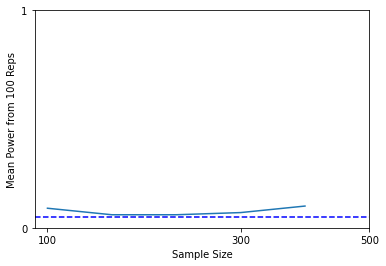

In [29]:
plot_power2()